In [1]:
import awkward as ak
import os
import pickle


import matplotlib.pyplot as plt
import numpy as np
plt.style.use("../science.mplstyle")

from helpers.physics_functions import *

In [2]:
muon_vars = ["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge", "Muon_tightId", "Muon_pfRelIso03_all", "Muon_pfRelIso04_all"]
jet_vars = ["Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass", "Jet_nConstituents", "Jet_btagCSVV2", "Jet_btagDeepB", "Jet_btagDeepFlavB", "MET_pt", "MET_sumEt"]

path_to_input = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/skimmed_data_2016H_30555/"
path_to_output = f"/pscratch/sd/r/rmastand/dimuonAD/compiled_data/etaj/"

num_files = 28


In [7]:


all_data = {

      "muon_iso03": [],
     "mu0_eta": [],
     "mu1_eta": [],
    "mu0_pt": [],
     "mu1_pt": [],
    "mu0_phi": [],
     "mu1_phi": [],
      "muon_iso04": [],
      "dimu_pt": [],
      "dimu_eta": [],
     "dimu_phi": [],
    
    
    "jet_pt": [],
    "jet_eta": [],
    
     "n_jets": [],
    "n_electrons": [],
     "n_muons": [],
    "jet_btag": [],
      "dimu_mass": [],
    }

a = list(all_data.keys())

for key in a:
    all_data[key+"_samesign"] = []


In [8]:
for i in range(num_files):
    
    print(f"Analyzing file {i+1} of {num_files}...")
    
    # LOAD IN DATA
    
    with open(f"{path_to_input}/all_mu_{i}", "rb") as input_file:
        loc_mu_feature = pickle.load(input_file)
        
    with open(f"{path_to_input}/all_jet_{i}", "rb") as input_file:
        loc_jet_feature = pickle.load(input_file)
        
    with open(f"{path_to_input}/all_e_{i}", "rb") as input_file:
        loc_e_feature = pickle.load(input_file)
        
    """
    # ALL MUONS

    muons = ak.zip({
        "pt": loc_mu_feature["Muon_pt"],
        "eta": loc_mu_feature["Muon_eta"],
        "phi": loc_mu_feature["Muon_phi"],
        "charge": loc_mu_feature["Muon_charge"],
        "iso03": loc_mu_feature["Muon_pfRelIso03_all"],
        "iso04": loc_mu_feature["Muon_pfRelIso04_all"],
            })

    muon_pairs = ak.combinations(muons, 2)
    mu1, mu2 = ak.unzip(muon_pairs)
    dimu_mass, dimu_pt, dimu_eta, _ = assemble_m_inv(muon_mass, mu1.pt, mu1.eta, mu1.phi, 
                                   muon_mass, mu2.pt,  mu2.eta,  mu2.phi)
    
    total_charge = mu1.charge + mu2.charge
    total_iso03 = mu1.iso03 + mu2.iso03
    total_iso04 = mu1.iso04 + mu2.iso04
    

    all_data["num_muon_pairs"].append(ak.count(dimu_mass[total_charge==0], axis = 1).to_numpy(allow_missing = True))
    
    all_data["n_muon"].append(ak.count(loc_mu_feature["Muon_charge"][loc_mu_feature["Muon_charge"]==-1], axis = 1).to_numpy(allow_missing = True))
    all_data["n_amuon"].append(ak.count(loc_mu_feature["Muon_charge"][loc_mu_feature["Muon_charge"]==1], axis = 1).to_numpy(allow_missing = True))
    all_data["dimu_mass_0"].append(ak.firsts(dimu_mass[total_charge==0]).to_numpy(allow_missing = True))
    
    loc_filter = ak.count(dimu_mass[total_charge==0], axis = 1) > 1
    all_data["dimu_mass_1"].append(dimu_mass[total_charge==0][loc_filter][:,1].to_numpy(allow_missing = True))
    
    loc_filter = ak.count(dimu_mass[total_charge==0], axis = 1) > 2
    all_data["dimu_mass_2"].append(dimu_mass[total_charge==0][loc_filter][:,2].to_numpy(allow_missing = True))
    """
    
    # 2 hard muons that pass tight ID
    
    event_filter = (np.sum(loc_mu_feature["Muon_tightId"], axis = 1) >= 2)# & ak.count(loc_jet_feature["Jet_pt"], axis = 1) >= 1
    
    def pull_tight_muons(feature):
        return loc_mu_feature[feature][loc_mu_feature["Muon_tightId"]][event_filter]
    

   
    dimu_mass, dimu_pt, dimu_eta, dimu_phi = assemble_m_inv(muon_mass, pull_tight_muons("Muon_pt")[:,0], pull_tight_muons("Muon_eta")[:,0], pull_tight_muons("Muon_phi")[:,0], 
                                   muon_mass, pull_tight_muons("Muon_pt")[:,1],  pull_tight_muons("Muon_eta")[:,1],  pull_tight_muons("Muon_phi")[:,1])
    
    
    total_charge = pull_tight_muons("Muon_charge")[:,0] + pull_tight_muons("Muon_charge")[:,1]
    total_iso03 = pull_tight_muons("Muon_pfRelIso03_all")[:,0] + pull_tight_muons("Muon_pfRelIso03_all")[:,1]
    total_iso04 = pull_tight_muons("Muon_pfRelIso04_all")[:,0] + pull_tight_muons("Muon_pfRelIso04_all")[:,1]
    
    # filters for opp-sign and same-sign muons; must apply *after* the event filter
    samesign_filter = np.abs(total_charge) == 2
    oppsign_filter = np.abs(total_charge) == 0

    # variables that have already had the event filter applied
    all_data["dimu_mass"].append(dimu_mass[oppsign_filter].to_numpy(allow_missing = True))
    all_data["dimu_pt"].append(dimu_pt[oppsign_filter].to_numpy(allow_missing = True))
    all_data["dimu_eta"].append(dimu_eta[oppsign_filter].to_numpy(allow_missing = True))
    all_data["dimu_phi"].append(dimu_phi[oppsign_filter].to_numpy(allow_missing = True))
 
    all_data["dimu_mass_samesign"].append(dimu_mass[samesign_filter].to_numpy(allow_missing = True))
    all_data["dimu_pt_samesign"].append(dimu_pt[samesign_filter].to_numpy(allow_missing = True))
    all_data["dimu_eta_samesign"].append(dimu_eta[samesign_filter].to_numpy(allow_missing = True))
    all_data["dimu_phi_samesign"].append(dimu_phi[samesign_filter].to_numpy(allow_missing = True))
  
    all_data["muon_iso03"].append(total_iso03[oppsign_filter].to_numpy(allow_missing = True))
    all_data["muon_iso03_samesign"].append(total_iso03[samesign_filter].to_numpy(allow_missing = True))
    
    all_data["muon_iso04"].append(total_iso04[oppsign_filter].to_numpy(allow_missing = True))
    all_data["muon_iso04_samesign"].append(total_iso04[samesign_filter].to_numpy(allow_missing = True))
    
    # variables that need the event filter
    all_data["n_jets"].append(ak.count(loc_jet_feature["Jet_mass"][event_filter], axis = 1)[oppsign_filter].to_numpy(allow_missing = True))
    all_data["n_jets_samesign"].append(ak.count(loc_jet_feature["Jet_mass"][event_filter], axis = 1)[samesign_filter].to_numpy(allow_missing = True))
    
    all_data["n_muons"].append(ak.count(pull_tight_muons("Muon_charge"), axis = 1)[oppsign_filter].to_numpy(allow_missing = True))
    all_data["n_muons_samesign"].append(ak.count(pull_tight_muons("Muon_charge"), axis = 1)[samesign_filter].to_numpy(allow_missing = True))
    
    all_data["n_electrons"].append(ak.count(loc_e_feature["Electron_pt"][event_filter], axis = 1)[oppsign_filter].to_numpy(allow_missing = True))
    all_data["n_electrons_samesign"].append(ak.count(loc_e_feature["Electron_pt"][event_filter], axis = 1)[samesign_filter].to_numpy(allow_missing = True))
    
    all_data["jet_btag"].append(ak.firsts(loc_jet_feature["Jet_btagDeepB"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
    all_data["jet_btag_samesign"].append(ak.firsts(loc_jet_feature["Jet_btagDeepB"][event_filter])[samesign_filter].to_numpy(allow_missing = True))
    
    all_data["jet_pt"].append(ak.firsts(loc_jet_feature["Jet_pt"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
    all_data["jet_pt_samesign"].append(ak.firsts(loc_jet_feature["Jet_pt"][event_filter])[samesign_filter].to_numpy(allow_missing = True))
    
    all_data["jet_eta"].append(ak.firsts(loc_jet_feature["Jet_eta"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
    all_data["jet_eta_samesign"].append(ak.firsts(loc_jet_feature["Jet_eta"][event_filter])[samesign_filter].to_numpy(allow_missing = True))
    

    all_data["mu0_eta"].append(pull_tight_muons("Muon_eta")[oppsign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu0_eta_samesign"].append(pull_tight_muons("Muon_eta")[samesign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu1_eta"].append(pull_tight_muons("Muon_eta")[oppsign_filter][:,1].to_numpy(allow_missing = True))
    all_data["mu1_eta_samesign"].append(pull_tight_muons("Muon_eta")[samesign_filter][:,1].to_numpy(allow_missing = True))

    all_data["mu0_pt"].append(pull_tight_muons("Muon_pt")[oppsign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu0_pt_samesign"].append(pull_tight_muons("Muon_pt")[samesign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu1_pt"].append(pull_tight_muons("Muon_pt")[oppsign_filter][:,1].to_numpy(allow_missing = True))
    all_data["mu1_pt_samesign"].append(pull_tight_muons("Muon_pt")[samesign_filter][:,1].to_numpy(allow_missing = True))

    
    all_data["mu0_phi"].append(pull_tight_muons("Muon_phi")[oppsign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu0_phi_samesign"].append(pull_tight_muons("Muon_phi")[samesign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu1_phi"].append(pull_tight_muons("Muon_phi")[oppsign_filter][:,1].to_numpy(allow_missing = True))
    all_data["mu1_phi_samesign"].append(pull_tight_muons("Muon_phi")[samesign_filter][:,1].to_numpy(allow_missing = True))

    
    """
    all_data["muon_iso04"].append(ak.firsts(loc_mu_feature["Muon_pfRelIso04_all"][loc_muon_filter][mp_event_filter]).to_numpy(allow_missing = True))
    all_data["amuon_iso04"].append(ak.firsts(loc_mu_feature["Muon_pfRelIso04_all"][loc_amuon_filter][mp_event_filter]).to_numpy(allow_missing = True))
  
    all_data["muon_iso03"].append(ak.firsts(loc_mu_feature["Muon_pfRelIso03_all"][loc_muon_filter][mp_event_filter]).to_numpy(allow_missing = True))
    all_data["amuon_iso03"].append(ak.firsts(loc_mu_feature["Muon_pfRelIso03_all"][loc_amuon_filter][mp_event_filter]).to_numpy(allow_missing = True))
  
    all_data["muon_pt"].append(ak.firsts(loc_mu_feature["Muon_pt"][loc_muon_filter][mp_event_filter]).to_numpy(allow_missing = True))
    all_data["amuon_pt"].append(ak.firsts(loc_mu_feature["Muon_pt"][loc_amuon_filter][mp_event_filter]).to_numpy(allow_missing = True))
    all_data["muon_eta"].append(ak.firsts(loc_mu_feature["Muon_eta"][loc_muon_filter][mp_event_filter]).to_numpy(allow_missing = True))
    all_data["amuon_eta"].append(ak.firsts(loc_mu_feature["Muon_eta"][loc_amuon_filter][mp_event_filter]).to_numpy(allow_missing = True))
    """


 
print("Done!")
    
    

Analyzing file 1 of 28...
Analyzing file 2 of 28...
Analyzing file 3 of 28...
Analyzing file 4 of 28...
Analyzing file 5 of 28...
Analyzing file 6 of 28...
Analyzing file 7 of 28...
Analyzing file 8 of 28...
Analyzing file 9 of 28...
Analyzing file 10 of 28...
Analyzing file 11 of 28...
Analyzing file 12 of 28...
Analyzing file 13 of 28...
Analyzing file 14 of 28...


/global/homes/r/rmastand/.conda/envs/cernroot/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


Analyzing file 15 of 28...
Analyzing file 16 of 28...
Analyzing file 17 of 28...
Analyzing file 18 of 28...
Analyzing file 19 of 28...
Analyzing file 20 of 28...
Analyzing file 21 of 28...
Analyzing file 22 of 28...
Analyzing file 23 of 28...
Analyzing file 24 of 28...
Analyzing file 25 of 28...
Analyzing file 26 of 28...
Analyzing file 27 of 28...
Analyzing file 28 of 28...
Done!


In [9]:
for key in all_data.keys():
    
    all_data[key] = np.hstack(all_data[key])
    print(key, all_data[key].shape)

    
    
    

muon_iso03 (21803678,)
mu0_eta (21803678,)
mu1_eta (21803678,)
mu0_pt (21803678,)
mu1_pt (21803678,)
mu0_phi (21803678,)
mu1_phi (21803678,)
muon_iso04 (21803678,)
dimu_pt (21803678,)
dimu_eta (21803678,)
dimu_phi (21803678,)
jet_pt (21803678,)
jet_eta (21803678,)
n_jets (21803678,)
n_electrons (21803678,)
n_muons (21803678,)
jet_btag (21803678,)
dimu_mass (21803678,)
muon_iso03_samesign (6756613,)
mu0_eta_samesign (6756613,)
mu1_eta_samesign (6756613,)
mu0_pt_samesign (6756613,)
mu1_pt_samesign (6756613,)
mu0_phi_samesign (6756613,)
mu1_phi_samesign (6756613,)
muon_iso04_samesign (6756613,)
dimu_pt_samesign (6756613,)
dimu_eta_samesign (6756613,)
dimu_phi_samesign (6756613,)
jet_pt_samesign (6756613,)
jet_eta_samesign (6756613,)
n_jets_samesign (6756613,)
n_electrons_samesign (6756613,)
n_muons_samesign (6756613,)
jet_btag_samesign (6756613,)
dimu_mass_samesign (6756613,)


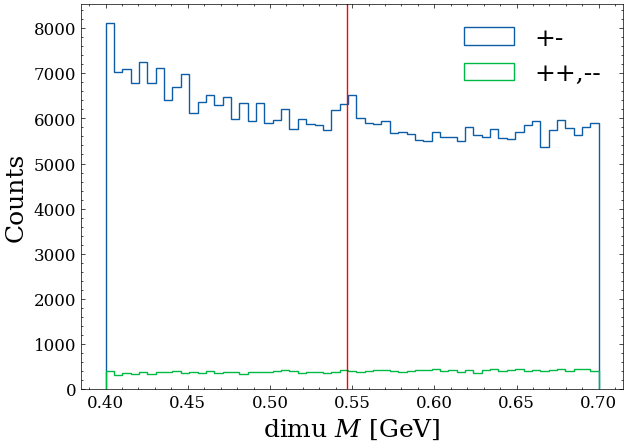

In [14]:


plt.figure()

plt.hist(all_data["dimu_mass"], bins = np.linspace(0.4, 0.7, 60), histtype = "step", label = "+-", density = False)
plt.hist(all_data["dimu_mass_samesign"], bins = np.linspace(0.4, 0.7, 60), histtype = "step", label = "++,--", density = False)

plt.axvline(0.547, color = "r")

plt.legend()
plt.ylabel("Counts")
plt.xlabel("dimu $M$ [GeV]")
plt.show()

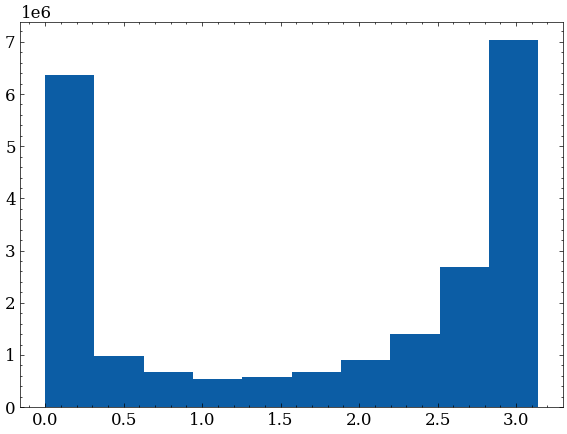

In [11]:
# calculate delta R

delta_phi = np.abs(all_data["mu0_phi"] - all_data["mu1_phi"])
# adjust to be in the range(-pi, pi)
delta_phi = np.where(delta_phi > np.pi, 2*np.pi - delta_phi, delta_phi)

plt.figure()
plt.hist(delta_phi)
plt.show()

delta_R = np.sqrt(delta_phi**2 + (all_data["mu0_eta"] - all_data["mu1_eta"])**2)

delta_pT = all_data["mu0_pt"] - all_data["mu1_pt"]


all_data["mumu_deltaR"] = delta_R
all_data["mumu_deltapT"] = delta_pT


delta_phi = np.abs(all_data["mu0_phi_samesign"] - all_data["mu1_phi_samesign"])
# adjust to be in the range(-pi, pi)
delta_phi = np.where(delta_phi > np.pi, 2*np.pi - delta_phi, delta_phi)

delta_R = np.sqrt(delta_phi**2 + (all_data["mu0_eta_samesign"] - all_data["mu1_eta_samesign"])**2)

delta_pT = all_data["mu0_pt_samesign"] - all_data["mu1_pt_samesign"]


all_data["mumu_deltaR_samesign"] = delta_R
all_data["mumu_deltapT_samesign"] = delta_pT



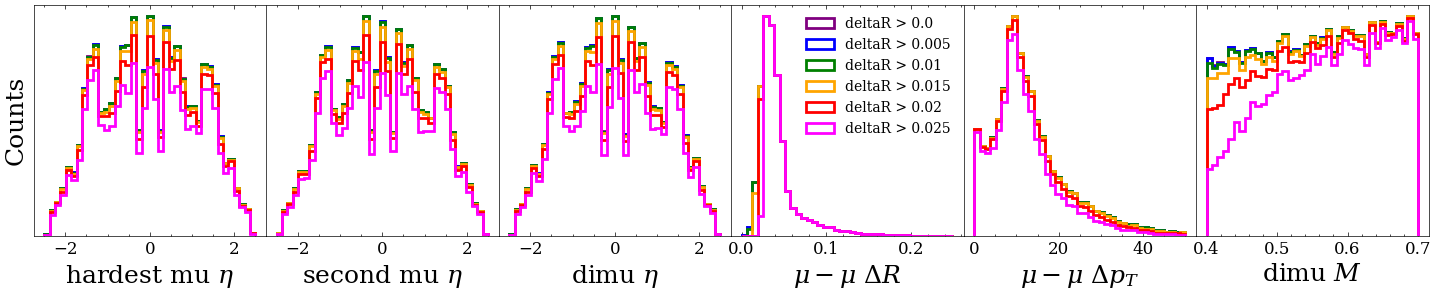

In [12]:
nb = 40
mass_low, mass_high = 0.4, 0.7

keys_to_plot =  ["mu0_eta", "mu1_eta", "dimu_eta", "mumu_deltaR", "mumu_deltapT", "dimu_mass"]
labels = ["hardest mu $\eta$","second mu $\eta$", "dimu $\eta$", "$\mu-\mu$ $\Delta R$", "$\mu-\mu$ $\Delta p_T$", "dimu $M$"]
bins = [np.linspace(-2.5, 2.5, nb), np.linspace(-2.5, 2.5, nb),np.linspace(-2.5, 2.5, nb), np.linspace(0, .25, nb),np.linspace(0, 50, nb), np.linspace(mass_low, mass_high, nb)]
n_features = len(keys_to_plot)




eta_min, eta_max = -8, 8
event_filter_opp =  (all_data["mumu_deltaR"] > 0.0)  & (all_data["dimu_mass"] > mass_low)  & (all_data["dimu_mass"] < mass_high) & (all_data["mu0_eta"] < eta_max) & (all_data["mu0_eta"] > eta_min)
event_filter_ss =  (all_data["mumu_deltaR_samesign"] > 0.00)  & (all_data["dimu_mass_samesign"] > mass_low)  & (all_data["dimu_mass_samesign"] < mass_high) & (all_data["mu0_eta_samesign"] < eta_max) & (all_data["mu0_eta_samesign"] > eta_min)


colors = ["purple", "blue", "green", "orange", "red", "magenta"]

fig, ax = plt.subplots(1, n_features, figsize = (3*n_features, 3))

for i, key in enumerate(keys_to_plot):
    
    for j, delta_R_min in enumerate([0., 0.005, 0.01, 0.015, 0.02, 0.025]):
    
        event_filter_opp =  (all_data["mumu_deltaR"] >delta_R_min)  & (all_data["dimu_mass"] > mass_low)  & (all_data["dimu_mass"] < mass_high) & (all_data["mu0_eta"] < eta_max) & (all_data["mu0_eta"] > eta_min)
        event_filter_ss =  (all_data["mumu_deltaR_samesign"] > delta_R_min)  & (all_data["dimu_mass_samesign"] > mass_low)  & (all_data["dimu_mass_samesign"] < mass_high) & (all_data["mu0_eta_samesign"] < eta_max) & (all_data["mu0_eta_samesign"] > eta_min)

        if delta_R_min == 0:
            label0 = "opp. sign"
            label1 = "same sign"
        else:
            label0 = None
            label1 = None

        #ax[i].hist(all_data[key][event_filter_opp], bins= bins[i], histtype = "step", label = label0, density = True, color = colors[j])
        ax[i].hist(all_data[key+"_samesign"][event_filter_ss], bins= bins[i], histtype = "step", lw = 2, label = "deltaR > " + str(delta_R_min), density = False, color = colors[j])


 
    ax[i].set_xlabel(labels[i])
    ax[i].set_yticks([])
    
ax[3].legend(fontsize = 10)
ax[0].set_ylabel("Counts")

plt.subplots_adjust(wspace=0)
plt.show()




/global/homes/r/rmastand/.conda/envs/cernroot/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


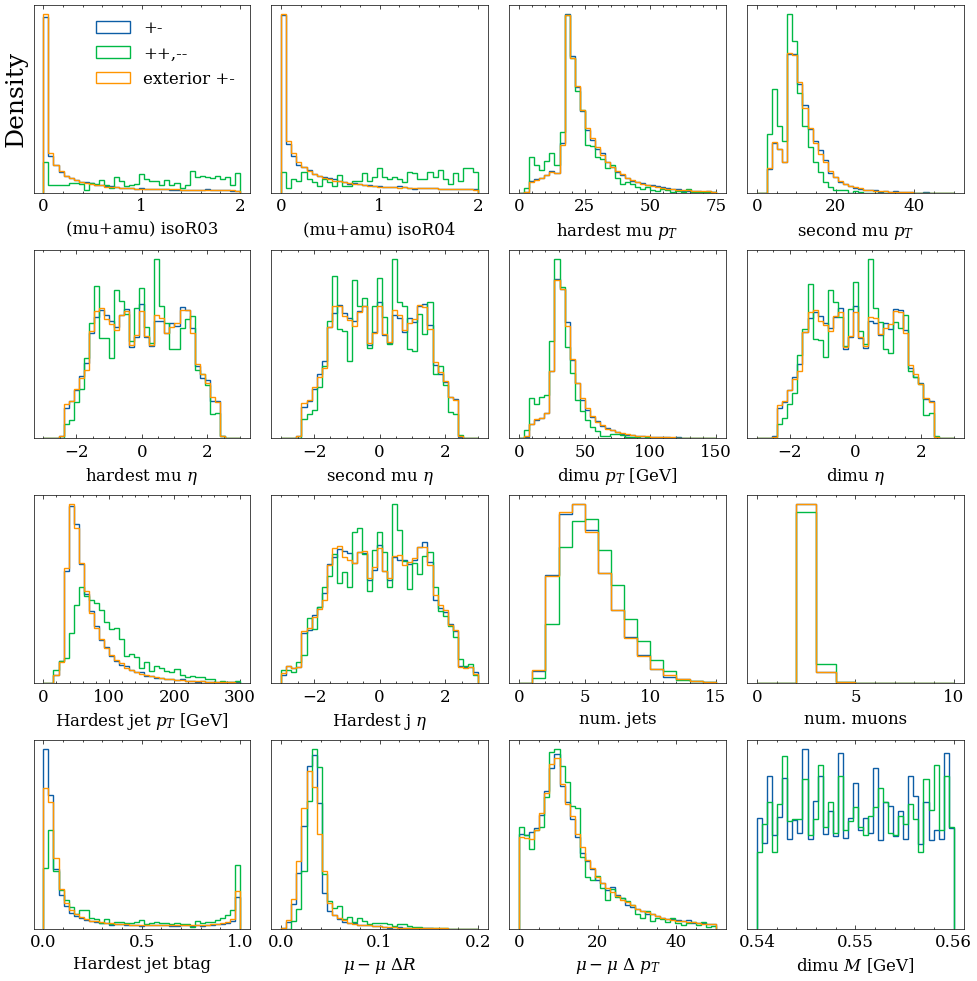

In [13]:
nb = 40

keys_to_plot =  ["muon_iso03", "muon_iso04","mu0_pt", "mu1_pt",  
                 "mu0_eta", "mu1_eta", "dimu_pt", "dimu_eta",
                 "jet_pt", "jet_eta", "n_jets", 
                 "n_muons", "jet_btag",  "mumu_deltaR", "mumu_deltapT", "dimu_mass"]

labels = ["(mu+amu) isoR03", "(mu+amu) isoR04", "hardest mu $p_T$","second mu $p_T$",
          "hardest mu $\eta$","second mu $\eta$", "dimu $p_T$ [GeV]", "dimu $\eta$",
          "Hardest jet $p_T$ [GeV]",   "Hardest j $\eta$",     "num. jets",
          "num. muons",   "Hardest jet btag",    "$\mu-\mu$ $\Delta R$","$\mu-\mu$ $\Delta$ $p_T$", "dimu $M$ [GeV]"]

n_features = len(keys_to_plot)

mass_low, mass_high = 0.54, 0.56

bins = [np.linspace(0, 2, nb),np.linspace(0, 2, nb), np.linspace(0, 75, nb),np.linspace(0, 50, nb),
        np.linspace(-3, 3, nb), np.linspace(-3, 3, nb),   np.linspace(0, 150, nb),np.linspace(-3, 3, nb),
        np.linspace(0, 300, nb),  np.linspace(-3, 3, nb), np.linspace(0, 15, 16),
        np.linspace(0, 10, 11),np.linspace(0, 1, nb), np.linspace(0, 0.2, nb), np.linspace(0, 50, nb), np.linspace(mass_low, mass_high, nb)]

event_filter_opp = (all_data["dimu_mass"] > mass_low)  & (all_data["dimu_mass"] < mass_high)
event_filter_ss = (all_data["dimu_mass_samesign"] > mass_low)  & (all_data["dimu_mass_samesign"] < mass_high)
event_filter_outrange = ((all_data["dimu_mass"] < mass_low)  | (all_data["dimu_mass"] > mass_high) ) & ( (all_data["dimu_mass"] < 0.65))& ( (all_data["dimu_mass"] > 0.45))


fig, ax = plt.subplots(4, 4, figsize = (12, 12))

for i, key in enumerate(keys_to_plot):


    ax.flat[i].hist(all_data[key][event_filter_opp], bins= bins[i], histtype = "step", label = "+-", density = True)
    ax.flat[i].hist(all_data[key+"_samesign"][event_filter_ss], bins= bins[i], histtype = "step", label = "++,--", density = True)
    ax.flat[i].hist(all_data[key][event_filter_outrange], bins= bins[i], histtype = "step", label = "exterior +-", density = True)
    
    
    
    
    ax.flat[i].set_xlabel(labels[i], fontsize = 12)
    ax.flat[i].set_yticks([])
    
ax.flat[0].legend(fontsize = 12)
ax.flat[0].set_ylabel("Density")

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

In [ ]:
plt.figure()

plt.hist(all_data["num_muon_pairs"], bins = np.linspace(-0.5, 9.5, 11), histtype = "step")
plt.xlabel("num. dimu +- pairs per event")
plt.show()





In [ ]:
plt.figure()

plt.hist(all_data["n_muon"], bins = np.linspace(-0.5, 5.5, 7), label = "muon", histtype = "step")
plt.hist(all_data["n_amuon"], bins = np.linspace(-0.5, 5.5, 7), label = "amuon", histtype = "step")
plt.xlabel("num. particles")
plt.legend()
plt.show()




In [ ]:


plt.figure()

plt.hist(all_data["dimu_mass_0"], bins = np.linspace(0.2, 0.7, 60), histtype = "step", label = "first")
plt.hist(all_data["dimu_mass_1"], bins = np.linspace(0.2, 0.7, 60), histtype = "step", label = "second")
plt.hist(all_data["dimu_mass_2"], bins = np.linspace(0.2, 0.7, 60), histtype = "step", label = "third")

plt.axvline(0.547, color = "r")

plt.legend()

plt.xlabel("dimu +- mass")
plt.show()

In [ ]:
with open(f"{path_to_output}/DATA", "wb") as output_file:
        pickle.dump(all_data, output_file)